Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE.txt and README.txt for information on usage and licensing

# SEIR Data Analysis

In [1]:
import collections, os, pickle
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import random, scipy
from tqdm.notebook import tqdm
from scipy import stats

from utils import *
import EoN

import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.style.use('figures/theme_bw.mplstyle')
%matplotlib inline

fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
## load the contact networks
#G_pre = nx.read_weighted_edgelist("data/G_pre.adjlist", nodetype=float)
#G_post = nx.read_weighted_edgelist("data/G_post.adjlist", nodetype=float)

## get the number of nodes in each graph
#N_pre = G_pre.number_of_nodes()
#N_post = G_post.number_of_nodes()
#N_dict = {'pre':N_pre, 'post':N_post}

## I'll skip loading the graphs into memory for now
N_pre = 214393
N_post = 130910
N_dict = {'pre': N_pre, 'post': N_post};

In [3]:
## load the simulation parameters
beta = np.load('data/SEIR/beta.npy')

flist_pre_uniform = np.load('data/SEIR/flist_pre_uniform.npy')
flist_pre_targeted = np.load('data/SEIR/flist_pre_targeted.npy')
flist_post_uniform = np.load('data/SEIR/flist_post_uniform.npy')
flist_post_targeted = np.load('data/SEIR/flist_post_targeted.npy')

f_dict = {
    ('pre', 'uniform'): flist_pre_uniform,
    ('pre', 'targeted'): flist_pre_targeted,
    ('post', 'uniform'): flist_post_uniform,
    ('post', 'targeted'): flist_post_targeted
         }

flist_small = [0.01, 0.02, 0.04, 0.08]

In [4]:
beta

array(1.3365)

In [5]:
def loader(socialdist, vacc, vacc_f=None, Rmax=1000):
    '''load the results'''
    
    if vacc_f == None:
        name = socialdist + '_' + vacc
    else:
        name = socialdist + '_' + vacc + '_' + str(vacc_f)        
    
    with open('data/SEIR/results_' + name + '.txt', 'rb') as file:
        result = pickle.load(file)

        ## discard any runs for which the epidemic dies out without infecting too many people
        result['t'] = [result['t'][i] for i in range(len(result['t'])) if result['R'][i][-1] > Rmax]
        result['S'] = [result['S'][i] for i in range(len(result['S'])) if result['R'][i][-1] > Rmax]
        result['E'] = [result['E'][i] for i in range(len(result['E'])) if result['R'][i][-1] > Rmax]
        result['I'] = [result['I'][i] for i in range(len(result['I'])) if result['R'][i][-1] > Rmax]    
        result['R'] = [result['R'][i] for i in range(len(result['R'])) if result['R'][i][-1] > Rmax]
        
    return result

## Plots

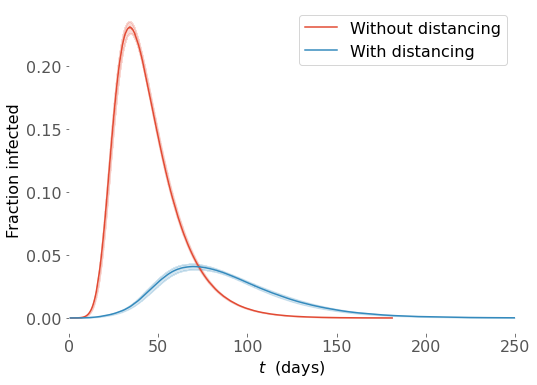

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(False)

socialdist = 'pre'
vacc = 'none'
result = loader(socialdist, vacc)
t_int, results_int = interpolation(result['t'], result['I'])
mean, under, uppper = mean_confidence_interval(results_int/N_dict[socialdist])
ax.plot(t_int, mean, color=colormap[0], label='Without distancing')
ax.fill_between(t_int, under, uppper, color=colormap[0], alpha=0.2)

socialdist = 'post'
vacc = 'none'
result = loader(socialdist, vacc)
t_int, results_int = interpolation(result['t'], result['I'])
mean, under, uppper = mean_confidence_interval(results_int/N_dict[socialdist])
ax.plot(t_int, mean, color=colormap[1], label='With distancing')
ax.fill_between(t_int, under, uppper, color=colormap[1], alpha=0.2)

#ax.set_title('Effect of Social Distancing')
ax.set_xlabel('$t$  (days)')
ax.set_ylabel('Fraction infected')
ax.legend()
ax.set_xlim([0,250])

plt.savefig("figures/SEIR_SD_comparison.png", dpi=600)
plt.show()

In [7]:
socialdist = 'pre'
vacc = 'none'
result = loader(socialdist, vacc)
total_infected_pre = np.mean([result['R'][i][-1] for i in range(len(result['R']))])
peak_infected_pre = np.mean([np.max(result['I'][i]) for i in range(len(result['I']))])

socialdist = 'post'
vacc = 'none'
result = loader(socialdist, vacc)
total_infected_post = np.mean([result['R'][i][-1] for i in range(len(result['R']))])
peak_infected_post = np.mean([np.max(result['I'][i]) for i in range(len(result['I']))])

print('total infected: pre: %2f, post: %2f' %(total_infected_pre, total_infected_post))
print('total peak infected: pre: %2f, post: %2f\n' %(peak_infected_pre, peak_infected_post))

print('reduction in total infected: %2f' %(1 - total_infected_post/total_infected_pre))
print('reduction in total peak infected: %2f\n' %(1 - peak_infected_post/peak_infected_pre))

print('reduction in fraction infected: %2f' %(1 - (total_infected_post*N_pre)/(total_infected_pre*N_post)))
print('reduction in fraction peak infected: %2f' %(1 - (peak_infected_post*N_pre)/(peak_infected_pre*N_post)))

total infected: pre: 128251.430108, post: 29151.925926
total peak infected: pre: 51398.118280, post: 5955.370370

reduction in total infected: 0.772697
reduction in total peak infected: 0.884133

reduction in fraction infected: 0.627743
reduction in fraction peak infected: 0.810242


social dist = pre, vacc = uniform, j = 0, successful runs = 96
social dist = pre, vacc = uniform, j = 1, successful runs = 91
social dist = pre, vacc = uniform, j = 2, successful runs = 91
social dist = pre, vacc = uniform, j = 3, successful runs = 95
social dist = pre, vacc = targeted, j = 0, successful runs = 97
social dist = pre, vacc = targeted, j = 1, successful runs = 98
social dist = pre, vacc = targeted, j = 2, successful runs = 95
social dist = pre, vacc = targeted, j = 3, successful runs = 99
social dist = post, vacc = uniform, j = 0, successful runs = 78
social dist = post, vacc = uniform, j = 1, successful runs = 89
social dist = post, vacc = uniform, j = 2, successful runs = 81
social dist = post, vacc = uniform, j = 3, successful runs = 82
social dist = post, vacc = targeted, j = 0, successful runs = 97
social dist = post, vacc = targeted, j = 1, successful runs = 50


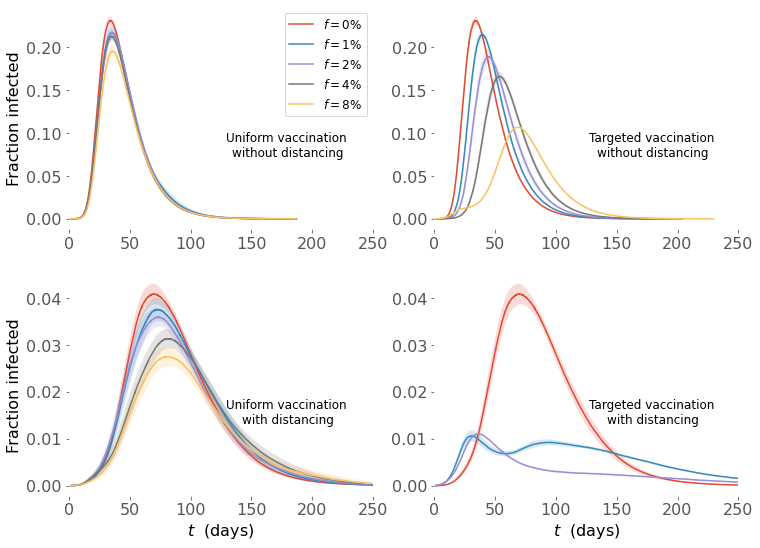

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))
axs = axs.flatten()
socialdists = ['pre', 'post']
socialdists2 = {'pre':'without', 'post':'with'}
vacc_strategies = ['uniform', 'targeted']
vacc_strategy_dic = {'uniform': 'Uniform', 'targeted':'Targeted'}

i = 0
for socialdist in socialdists:
    
    for vacc_strategy in vacc_strategies:
        ax = axs[i]
        
        ## plot results with no vaccination
        result = loader(socialdist, 'none')
        t_int, results_int = interpolation(result['t'], result['I'])
        mean, under, uppper = mean_confidence_interval(results_int/N_dict[socialdist])
        ax.plot(t_int, mean, label=r'$f = $%.0f%%' % (100*0.0))
        ax.fill_between(t_int, under, uppper, alpha=0.2)

        ## plot results with fractional vaccination
        for j in range(len(flist_small)):
            vacc_f = flist_small[j]        
            try:
                result = loader(socialdist, vacc_strategy, vacc_f)

                ## only plot results for which more than 10 of the simulations did not die out prematurely
                if len(result['R']) > 10:
                    print('social dist = %s, vacc = %s, j = %i, successful runs = %i' %(socialdist, vacc_strategy, j, len(result['R'])))
                    t_int, results_int = interpolation(result['t'], result['I'])
                    mean, under, uppper = mean_confidence_interval(results_int/N_dict[socialdist])
                    ax.plot(t_int, mean, label=r'$f = $%.0f%%' % (100*vacc_f))
                    ax.fill_between(t_int, under, uppper, alpha=0.2)
                    ax.set_xlim([0,250])
            except:
                pass
        
        ## add labels, titles, and legend
        ax.grid(False)
        #ax.set_title('SD: %s, vacc: %s' %(socialdist, vacc_strategy))        
        ax.set_title('%s vaccination \n%s distancing' %(vacc_strategy_dic[vacc_strategy], socialdists2[socialdist]), fontsize=12, x=0.72, y=0.3)
        if i in [2, 3]:
            ax.set_xlabel('$t$  (days)')
        if i in [0, 2]:
            ax.set_ylabel('Fraction infected')
        if i == 0:
            ax.legend(fontsize=12)
        
        i += 1
        
plt.savefig("figures/SEIR_SD_vacc_comparison.png", dpi=600)
plt.show()

The blue curve in the bottom-right plot looks a bit weird. Let's inspect the 100 runs used to estimate the mean and confidence interval. For good measure, let's do this for all 4 plots together.

social dist = pre, vacc = uniform, j = 0, successful runs = 96
social dist = pre, vacc = targeted, j = 0, successful runs = 97
social dist = post, vacc = uniform, j = 0, successful runs = 78
social dist = post, vacc = targeted, j = 0, successful runs = 97


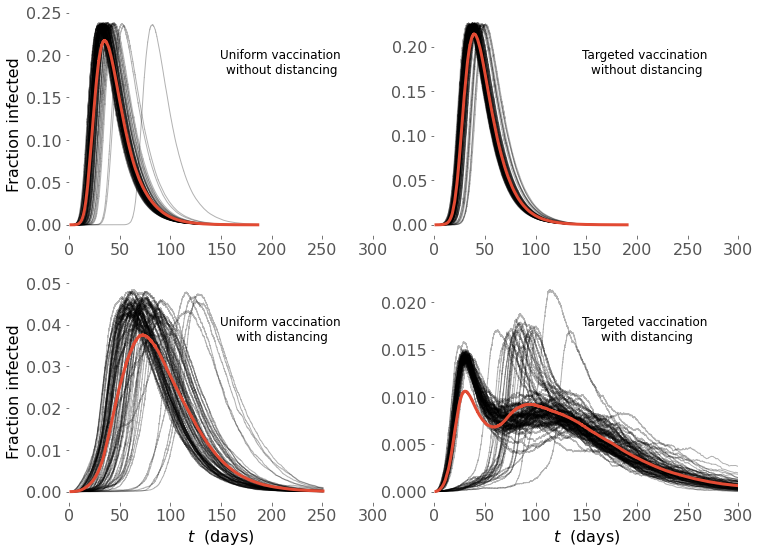

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))
axs = axs.flatten()
socialdists = ['pre', 'post']
socialdists2 = {'pre':'without', 'post':'with'}
vacc_strategies = ['uniform', 'targeted']
vacc_strategy_dic = {'uniform': 'Uniform', 'targeted':'Targeted'}

i = 0
for socialdist in socialdists:
    
    for vacc_strategy in vacc_strategies:
        ax = axs[i]

        ## plot results with fractional vaccination
        j = 0
        vacc_f = flist_small[j]        
        try:
            result = loader(socialdist, vacc_strategy, vacc_f)

            ## only plot results for which more than 10 of the simulations did not die out prematurely
            if len(result['R']) > 10:
                print('social dist = %s, vacc = %s, j = %i, successful runs = %i' %(socialdist, vacc_strategy, j, len(result['R'])))
                t_int, results_int = interpolation(result['t'], result['I'])
                mean, under, uppper = mean_confidence_interval(results_int/N_dict[socialdist])
                for k in range(len(results_int)):
                    ax.plot(t_int, results_int[k]/N_dict[socialdist], color='k', alpha=0.3, linewidth=1)
                ax.plot(t_int, mean, linewidth=3)
        except:
            pass
        
        ax.set_xlim([0,300])
        #ax.set_ylim([0,0.25])
        ax.grid(False)
        ax.set_title('%s vaccination \n%s distancing' %(vacc_strategy_dic[vacc_strategy], socialdists2[socialdist]), fontsize=12, x=0.7, y=0.7)
        if i in [2, 3]:
            ax.set_xlabel('$t$  (days)')
        if i in [0, 2]:
            ax.set_ylabel('Fraction infected')        
        i += 1
        
plt.savefig("figures/SEIR_closer_look.png", dpi=600)
plt.show()

How does the vaccination fraction affect the total number of infecteds?

In [10]:
def plotter_helper(socialdist, vacc, flist):
    mean = []
    std = []
    flist2 = []
    
    ## first handle the case with no vaccination
    result = loader(socialdist, 'none')
    if len(result['R']) > 10:
        flist2.append(0)
        mean.append(np.mean([result['R'][i][-1]/N_dict[socialdist] for i in range(len(result['R']))]))
        std.append(np.std([result['R'][i][-1]/N_dict[socialdist] for i in range(len(result['R']))]))
    
    ## then handle the fractional vaccinations
    for i in range(len(flist)):
        result = loader(socialdist, vacc, flist[i])
        if len(result['R']) > 5:
            flist2.append(flist[i])
            mean.append(np.mean([result['R'][i][-1]/N_dict[socialdist] for i in range(len(result['R']))]))
            std.append(np.std([result['R'][i][-1]/N_dict[socialdist] for i in range(len(result['R']))]))

    return np.asarray(flist2), np.asarray(mean), np.asarray(std)

First load up and process the data

In [11]:
flist_dic = {}
mean_dic = {}

for socialdist in socialdists:
    for vacc_strategy in vacc_strategies:
        flist2, mean, std = plotter_helper(socialdist, vacc_strategy, f_dict[(socialdist, vacc_strategy)])        
        flist_dic[(socialdist, vacc_strategy)] = flist2
        mean_dic[(socialdist, vacc_strategy)] = mean
        
        print(mean[-1])

0.00710912697160602
0.014162419152732433
0.01215678286184741
0.01600603468031472


Then make the plot

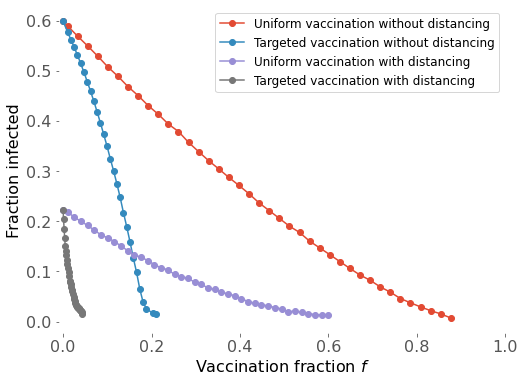

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(False)

linear_fit_dict = {}

socialdists = ['pre', 'post']
vacc_strategies = ['uniform', 'targeted']
i = 0
for socialdist in socialdists:
    for vacc_strategy in vacc_strategies:
        
        #ax.plot(flist2, mean, '-ok', color=colormap[i], label='SD: %s, vacc: %s' %(socialdist, vacc_strategy))
        ax.plot(flist_dic[(socialdist, vacc_strategy)], mean_dic[(socialdist, vacc_strategy)], '-ok', color=colormap[i], 
                label='%s vaccination %s distancing' %(vacc_strategy_dic[vacc_strategy], socialdists2[socialdist]))        
        #ax.errorbar(flist2, mean, yerr=std, fmt='-o', color=colormap[i], label='SD: %s, vacc: %s' %(socialdist, vacc_strategy))
        i += 1
                
ax.legend(fontsize=12)
ax.set_xlabel(r'Vaccination fraction $f$')
ax.set_ylabel(r'Fraction infected')
ax.set_xlim([-0.01,1])
plt.savefig("figures/SEIR_vacc_fraction.png", dpi=600)
plt.show()

Make a plot similar to Fig. 2b in Pastor-Satorras and Vespignani:

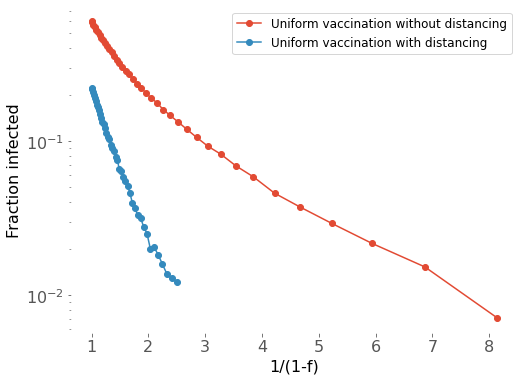

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
i = 0

ax.grid(False)
for socialdist in socialdists:
    for vacc_strategy in ['uniform']:
        ax.plot(1/(1-flist_dic[(socialdist, vacc_strategy)]), mean_dic[(socialdist, vacc_strategy)], '-ok', color=colormap[i],
               label='%s vaccination %s distancing' %(vacc_strategy_dic[vacc_strategy], socialdists2[socialdist]))
        i += 1
        
ax.set_xlabel('1/(1-f)')
ax.set_ylabel('Fraction infected')
ax.legend(fontsize=12)
#ax.set_xscale('log')
ax.set_yscale('log')

plt.savefig("figures/SEIR_vacc_fraction_vespignani.png", dpi=600)
plt.show()

Do a linear fit to find the x-intercept

In [14]:
k = 4 #use the last k data points
for socialdist in socialdists:
    for vacc_strategy in vacc_strategies:
        slope, intercept, r_value, p_value, std_err = stats.linregress(flist_dic[(socialdist, vacc_strategy)][-k:], mean_dic[(socialdist, vacc_strategy)][-k:])
        linear_fit_dict[socialdist + '_' + vacc_strategy] = -intercept/slope
        
linear_fit_dict

{'pre_uniform': 0.9003635551147696,
 'pre_targeted': 0.2264072014083955,
 'post_uniform': 0.744238991567501,
 'post_targeted': 0.05699218622314013}

Find the f value for which the infected fraction drops below some threshold value%.

In [15]:
for socialdist in socialdists:
    for vacc_strategy in vacc_strategies:
        flist2 = flist_dic[(socialdist, vacc_strategy)]
        mean = mean_dic[(socialdist, vacc_strategy)]
        for i in range(len(flist2)):
            if mean[i] < 0.02:
                print(socialdist, vacc_strategy, flist2[i], mean[i])
                break

pre uniform 0.8543589743589745 0.015253858627942667
pre targeted 0.20333333333333334 0.01635589661784547
post uniform 0.5092307692307692 0.01982148628241364
post targeted 0.04246153846153846 0.01863780459857918
